# Comparison of Texas Wind Power Capacity Estimates

Import required Python modules

In [131]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

Set directory path where geospatial data files are stored

In [132]:
#datapath = "/home/tomortiz/projects/geospatial/data"
datapath = "/home/tortiz/geospatial/data"

## NREL WINDExchange Total Technical Wind Power Capacity

The National Renewable Energy Laboratory (NREL) publishes maps and associated data tables to quantify the wind power potential over the entire United States.  These maps attempt to estimate the total technical wind power capacity without correcting for any anticipated or regulatory land use restrictions. Thus, the WINDExchange map data represent the gross, or maximum achievable wind power that can be developed.  The map for Texas extends to 50 nm offshore and is further subdivided by wind speed classes.

See:[Texas Technical Offshore Wind Capacity](https://windexchange.energy.gov/maps-data/233)

Following are the relevant Texas data values extracted manually from the PDF file available at the above link.

In [133]:
texas_50nm_total_wind = 278353.0
texas_9nm_total_wind = 8928.0 + 45230.0 + 29643.0 + 18990.0

In [134]:
texas_50nm_total_wind

278353.0

In [135]:
texas_9nm_total_wind

102791.0

We will return to these values after computing wind development potential estimates which consider land use restrictions.

## National Renewable Energy Laboratory Wind Supply Curves

The following supply curve wind power capacity estimates take into account varying assumptions about the availability of land for wind power development.  Open access siting assumptions limit land use based only on physical constraints or protected land status.  Limited access siting assumptions include NREL's most restrictive municipal setback and federal management requirements and thus represent the most conservative, or pessimistic, estimate of available wind development potential.

See:[Wind Supply Curves](https://www.nrel.gov/gis/wind-supply-curves.html)

In [136]:
nrel_open = pd.read_csv(datapath+"/NREL/offshore-wind-open-access-siting-regime-atb-mid-turbine-fy21.csv")
nrel_limit = pd.read_csv(datapath+"/NREL/offshore-wind-limited-access-siting-regime-atb-mid-turbine-fy21.csv")

In [137]:
nrel_open.head()

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km
0,0,49.028,-123.286,13.0653,69.437181,0.275788,6.634215,31.441526,-142.296967,9.739686
1,1,49.054,-123.138,3.6531,19.414860,0.270921,6.610088,31.441526,-44.682926,5.595797
2,2,48.942,-123.242,9.7686,51.916454,0.274557,6.625663,31.441526,-143.059708,8.746844
3,3,48.993,-122.948,8.0919,43.005421,0.239673,6.218549,31.441526,-2.659660,5.346195
4,4,48.855,-123.199,0.1701,0.904018,0.273975,6.630000,31.441526,-126.142860,9.316036


The CSV data from NREL must be converted from raw text to a geopandas GeoSeries in order to enable geospatial analysis.  Since we have latitude and longitude data, we apply a geodetic coordinate reference system suitable for North America (NAD83 - EPSG:4269)

See:[North America Geodetic CRS Codes](https://epsg.io/?q=North%20America%20kind%3AGEOGCRS)

In [138]:
nrel_open_geom = gpd.points_from_xy(nrel_open["longitude"], nrel_open["latitude"], crs="EPSG:4269")
nrel_limit_geom = gpd.points_from_xy(nrel_limit["longitude"], nrel_limit["latitude"], crs="EPSG:4269")

In [139]:
nrel_open_geom = gpd.GeoSeries(nrel_open_geom)
nrel_limit_geom = gpd.GeoSeries(nrel_limit_geom)

Add a "geometry" column to each DataFrame accordingly

In [140]:
nrel_open["geometry"] = nrel_open_geom
nrel_limit["geometry"] = nrel_limit_geom

And recast the DataFrame objects to type GeoDataFrame.  Geopandas will automatically recognize the new "geometry" column name as containing valid geolocation data.

In [141]:
nrel_open_gdf = gpd.GeoDataFrame(nrel_open)
nrel_limit_gdf = gpd.GeoDataFrame(nrel_limit)

The data also include effective surface areas associated with each wind capacity estimate, a capacity factor for that area, wind speed, water depth, and distances to the coast and to the nearest onshore electrical transmission tie-in point.

In [142]:
nrel_open_gdf.head()

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km,geometry
0,0,49.028,-123.286,13.0653,69.437181,0.275788,6.634215,31.441526,-142.296967,9.739686,POINT (-123.28600 49.02800)
1,1,49.054,-123.138,3.6531,19.414860,0.270921,6.610088,31.441526,-44.682926,5.595797,POINT (-123.13800 49.05400)
2,2,48.942,-123.242,9.7686,51.916454,0.274557,6.625663,31.441526,-143.059708,8.746844,POINT (-123.24200 48.94200)
3,3,48.993,-122.948,8.0919,43.005421,0.239673,6.218549,31.441526,-2.659660,5.346195,POINT (-122.94800 48.99300)
4,4,48.855,-123.199,0.1701,0.904018,0.273975,6.630000,31.441526,-126.142860,9.316036,POINT (-123.19900 48.85500)


## Texas General Land Office Offshore Tracts

The Texas General Land Office provides publicly accessible data files for mapping state-owned offshore land tracts.

See:[Texas GLO Maps and Data](https://www.glo.texas.gov/land/land-management/gis/index.html)

In [143]:
sub_land = gpd.read_file(datapath+"/SSL/SubmergedOTLS.shp")

We need to verify the coordinate reference system being used for these offshore tracts

In [144]:
sub_land.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In order to overlay our wind data onto plots of these offshore tracts, all of the GeoDataFrame objects must be projected onto the same coordinate reference system.  We will therefore project the geodetic data supplied by NREL onto the GLO reference frame.

In [145]:
nrel_open_gdf = nrel_open_gdf.to_crs("EPSG:3857")
nrel_limit_gdf = nrel_limit_gdf.to_crs("EPSG:3857")

If we begin by plotting data as a cloropleth map, we can see the variation of offshore wind capacity estimates over the entire United States coastline, including the Great Lakes.  However, the Texas state offshore tracts are difficult to visualize here.

<AxesSubplot:>

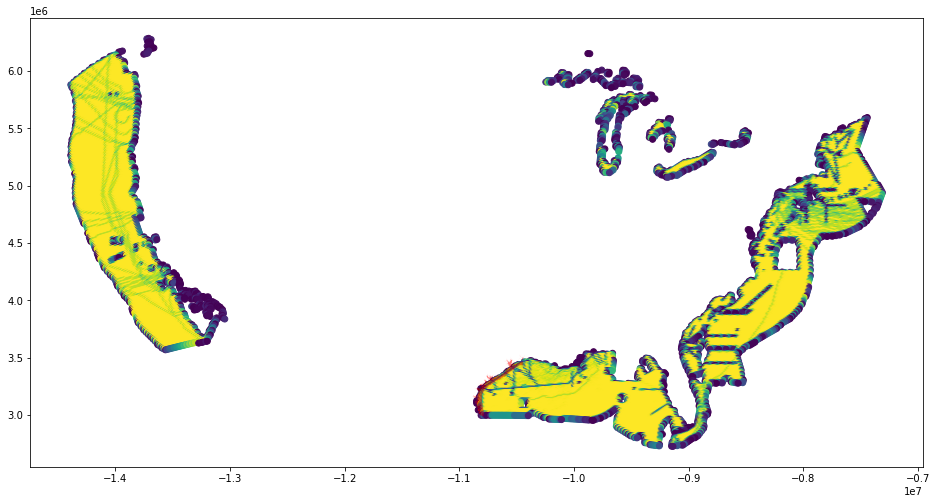

In [146]:
fig, ax = plt.subplots(figsize=(16,12))
nrel_open_gdf.plot(ax=ax, column="capacity_mw")
sub_land.plot(ax=ax, alpha=0.5, color="red")

## Focus on Wind Power Capacity in Texas State Waters

We can zoom in to focus on Texas state waters by returning bounding box coordinates for the GLO offshore tract data

In [147]:
sub_land.total_bounds

array([-10886936.8755,   2993523.1854, -10429325.1377,   3526649.6946])

Here we now see that, as expected, most of the NREL-estimated wind capacity is outside of Texas state waters, but that there are still significant high capacity areas that fall within the GLO offshore tracts.

<AxesSubplot:>

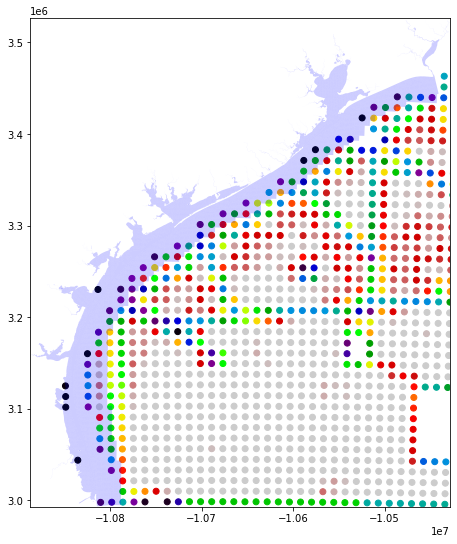

In [148]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-10887000, -10429000])
ax.set_ylim([2993000, 3527000])
nrel_open_gdf.plot(ax=ax, column="capacity_mw", cmap ="nipy_spectral")
sub_land.plot(ax=ax, alpha=0.2, color="blue")

In order to quantify wind power capacity in Texas state waters, we can perform a geospatial join on the NREL and GLO datasets, returning a new GeoDataFrame where NREL wind power capacity estimates fall within the GLO tracts.

In [149]:
wind_open_glo = gpd.sjoin(sub_land, nrel_open_gdf , how="left", op='intersects')
wind_limit_glo = gpd.sjoin(sub_land, nrel_limit_gdf , how="left", op='intersects')

We can sort the intersection data by capacity in MW in descending order if we want to highlight the highest value tracts.

<AxesSubplot:>

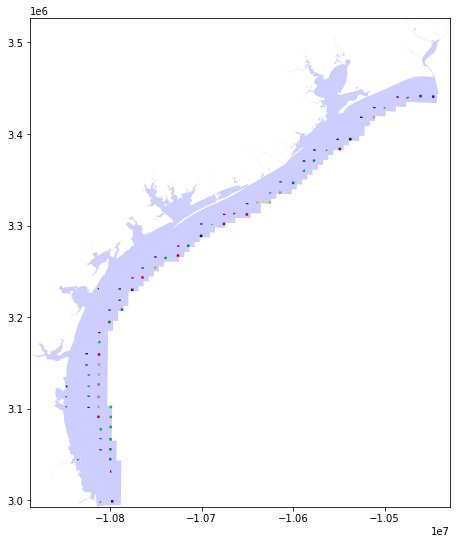

In [150]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-10887000, -10429000])
ax.set_ylim([2993000, 3527000])
wind_open_glo.plot(ax=ax, column="capacity_mw", cmap ="nipy_spectral")
sub_land.plot(ax=ax, alpha=0.2, color="blue")

In [151]:
wind_open_glo["capacity_mw"].sum()

16620.368303571428

<AxesSubplot:>

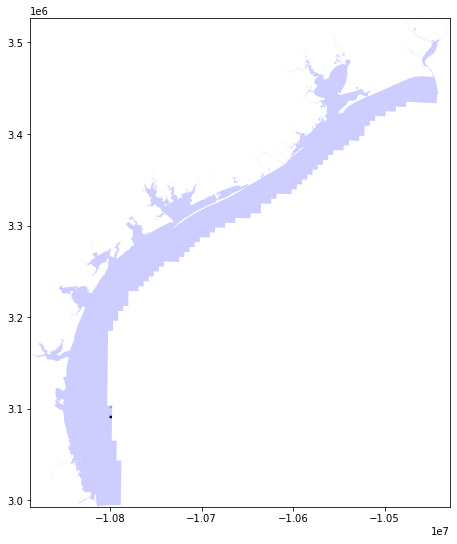

In [152]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-10887000, -10429000])
ax.set_ylim([2993000, 3527000])
wind_limit_glo.plot(ax=ax, column="capacity_mw", cmap ="nipy_spectral")
sub_land.plot(ax=ax, alpha=0.2, color="blue")

In [153]:
wind_limit_glo["capacity_mw"].sum()

72.61315237966468

If the strictest land use considerations are applied, only 73 MW of wind development capacity is predicted for Texas state waters by the NREL model; essentially nothing.

In [154]:
texas_all_wind_resource_levels = pd.DataFrame(np.array([[texas_50nm_total_wind, texas_9nm_total_wind, wind_open_glo["capacity_mw"].sum(), wind_limit_glo["capacity_mw"].sum()]]), columns=["Technical 50 nm", "Technical 9 nm", "Open Land Use", "Strict Land Use"])

In [155]:
texas_all_wind_resource_levels.head()

,Technical 50 nm,Technical 9 nm,Open Land Use,Strict Land Use
0,278353.0,102791.0,16620.368304,72.613152


<AxesSubplot:>

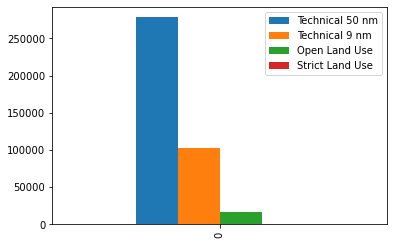

In [156]:
texas_all_wind_resource_levels.plot.bar()

Clearly, the strict land use case is so small to be insignificant by comparison.  The implication of this analysis is that, while Texas has substantial technical wind power potential both in state and federal waters, possible land use restrictions can make an orders-of-magnitude difference in the amount of economic development potential achievable.  For Texas state waters, the range spans 73 MW in the most pessimistic case to 16.6 GW assuming relatively open land use policies, to nearly 103 GW of actual technical wind development potential in the absence of any land use restrictions.

In [157]:
import requests
from html_table_parser.parser import HTMLTableParser

BOEM_NY_BIGHT_URL = "https://www.boem.gov/renewable-energy/state-activities/new-york-bight"

def url_get_contents(url):
    """ Opens a website and read its binary contents (HTTP Response Body) """
    req = requests.get(url, verify=False)
    return req


def scrape_tables(url):
    html = url_get_contents(url).text

    p = HTMLTableParser()
    p.feed(html)
    
    return p.tables

nyb_data = scrape_tables(BOEM_NY_BIGHT_URL)

/home/tortiz/anaconda3/envs/geospatial/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.boem.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [158]:
# Reorganize lease data into list of dictionaries

for table in nyb_data:
    headers = []
    rows = []
    for row in table:
        j = 0
        for col in row:
            if j == 0:
                headers.append(row[j])
            else:
                rows.append([])
                rows[j-1].append(row[j])
            j += 1
    headers[0] = "ID"
    
    leases = []
    for row in rows:
        if len(row) != 0:
            leases.append(row)
    
    lease_data = []
    i = 0
    for lease in leases:
        j = 0
        lease_data.append({})
        for attribute in lease:
            (lease_data[i])[headers[j]] = attribute
            j += 1
        i += 1

#print(lease_data)

In [159]:
# Merge auction results into lease dictionaries
import json

with open(datapath+"/BOEM/nybsales.json", 'r') as file:
    auction_results = json.load(file)

#print(auction_results)
merged_lease_data = []
for lease_id in lease_data:
    for lease in auction_results["leases"]:
        if lease["id"] == lease_id["ID"]:
            merged_lease_data.append(lease_id)
            for key in lease:
                (merged_lease_data[-1])[key] = lease[key]

#print(merged_lease_data)

In [160]:
# Create DataFrame to interrogate merged lease data

merged_df = pd.DataFrame(merged_lease_data)

#merged_df.head()

In [161]:
import locale
from locale import atof

clean_merged_cf = merged_df.drop(["id"], axis=1)
clean_merged_cf.replace(',','', regex=True, inplace=True)

locale.setlocale(locale.LC_NUMERIC, '')
clean_merged_cf["Acres"] = clean_merged_cf["Acres"].map(atof)
clean_merged_cf["Developable Acres"] = clean_merged_cf["Developable Acres"].map(atof)
clean_merged_cf["Installation Capacity (MW) [1]"] = clean_merged_cf["Installation Capacity (MW) [1]"].map(atof)
clean_merged_cf["Homes powered [2]"] = clean_merged_cf["Homes powered [2]"].map(atof)
clean_merged_cf["Power Production (MWh/yr) [3]"] = clean_merged_cf["Power Production (MWh/yr) [3]"].map(atof)
clean_merged_cf["Max Depth (meters[m])"] = clean_merged_cf["Max Depth (meters[m])"].map(atof)
clean_merged_cf["Min Depth (m)"] = clean_merged_cf["Min Depth (m)"].map(atof)
clean_merged_cf["Closest distance to NY (nautical mile [nmi])"] = clean_merged_cf["Closest distance to NY (nautical mile [nmi])"].map(atof)
clean_merged_cf["Closest distance to NJ (nmi)"] = clean_merged_cf["Closest distance to NJ (nmi)"].map(atof)
clean_merged_cf["bid"] = clean_merged_cf["bid"].map(float)

clean_merged_cf.head()

,ID,Acres,Developable Acres,Installation Capacity (MW) [1],Homes powered [2],Power Production (MWh/yr) [3],Max Depth (meters[m]),Min Depth (m),Closest distance to NY (nautical mile [nmi]),Closest distance to NJ (nmi),operator,bid
0,OCS-A 0537,71522.0,71522.0,868.0,303911.0,3042588.0,61.0,50.0,38.0,53.0,OW Ocean Winds East LLC,7.650000e+08
1,OCS-A 0538,84332.0,79438.0,964.0,337548.0,3379340.0,63.0,37.0,47.0,36.0,Attentive Energy LLC,7.950000e+08
2,OCS-A 0539,125964.0,114277.0,1387.0,485586.0,4861411.0,51.0,31.0,56.0,32.0,Bight Wind Holdings LLC,1.100000e+09
3,OCS-A 0541,79351.0,76139.0,924.0,323530.0,3238998.0,51.0,31.0,65.0,27.0,Atlantic Shores Offshore Wind Bight LLC,7.800000e+08
4,OCS-A 0542,83976.0,76894.0,934.0,326738.0,3271116.0,54.0,32.0,69.0,35.0,Invenergy Wind Offshore LLC,6.450000e+08


In [162]:
clean_merged_cf["Price Per Acre"] = clean_merged_cf.apply(lambda row: row["bid"]/row["Developable Acres"], axis=1)
print(clean_merged_cf)

           ID     Acres  Developable Acres  Installation Capacity (MW) [1]  \
0  OCS-A 0537   71522.0            71522.0                           868.0   
1  OCS-A 0538   84332.0            79438.0                           964.0   
2  OCS-A 0539  125964.0           114277.0                          1387.0   
3  OCS-A 0541   79351.0            76139.0                           924.0   
4  OCS-A 0542   83976.0            76894.0                           934.0   
5  OCS-A 0544   43056.0            43056.0                           523.0   

   Homes powered [2]  Power Production (MWh/yr) [3]  Max Depth (meters[m])  \
0           303911.0                      3042588.0                   61.0   
1           337548.0                      3379340.0                   63.0   
2           485586.0                      4861411.0                   51.0   
3           323530.0                      3238998.0                   51.0   
4           326738.0                      3271116.0            

In [163]:
boem_planning_areas = gpd.read_file(datapath+"/BOEM/BOEMWindPlanningAreasJan12_2022.shp")

In [164]:
boem_planning_areas.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [165]:
boem_planning_areas = boem_planning_areas.to_crs("EPSG:3857")

<AxesSubplot:>

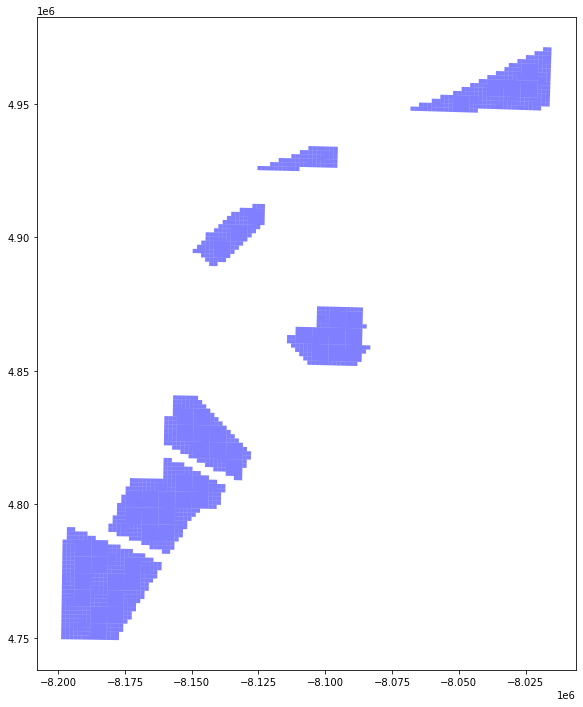

In [166]:
#boem_planning_areas.head()
nyb_geom = boem_planning_areas[boem_planning_areas["INFO"].str.contains("^.*Bight.*$")]

fig, ax = plt.subplots(figsize=(16,12))
nyb_geom.plot(ax=ax, alpha=0.5, color="blue")

In [167]:
#nyb_geom.head()
ocs_a_0544_geom = nyb_geom[nyb_geom["INFO"].str.contains("^.*OCS-A\s*0544.*$")]
ocs_a_0544_geom.total_bounds

array([-8149654.56252254,  4889220.92186838, -8122558.68267174,
        4912582.07694709])

<AxesSubplot:>

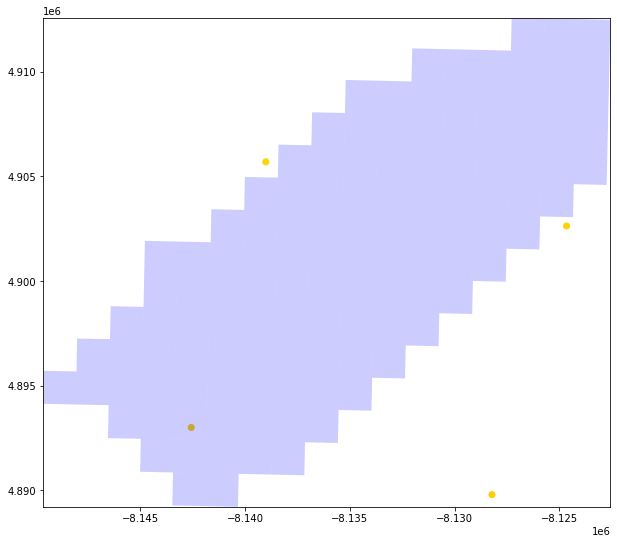

In [168]:
# need to overlay wind speeds onto each NY Bight lease geometry filtered by lease ID

#nrel_open_gdf.head()
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-8149654.56252254, -8122558.68267174])
ax.set_ylim([4889220.92186838, 4912582.07694709])
nrel_open_gdf.plot(ax=ax, column="wind_speed_150meters", cmap ="nipy_spectral")
ocs_a_0544_geom.plot(ax=ax, alpha=0.2, color="blue")

In [169]:
ocs_a_0544_wind_speeds = gpd.sjoin(nrel_open_gdf, ocs_a_0544_geom)
ocs_a_0544_wind_speeds

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km,...,PROT_NUMBE,BLOCK_NUMB,BLOCK_LAB,SUB_BLK,LINK1,LINK2,CAT1,OBJECTID,Shape_Leng,Shape_Area
5720,5720,40.186,-73.146,95.7582,508.919005,0.443239,9.253782,5.5,-41.134243,51.933051,...,NK18-12,6863P,6863,P,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0


In [170]:
ocs_a_0537_geom = nyb_geom[nyb_geom["INFO"].str.contains("^.*OCS-A\s*0537.*$")]
ocs_a_0537_geom.total_bounds

array([-8114361.19826695,  4851827.76684288, -8083105.2395973 ,
        4874200.74436741])

<AxesSubplot:>

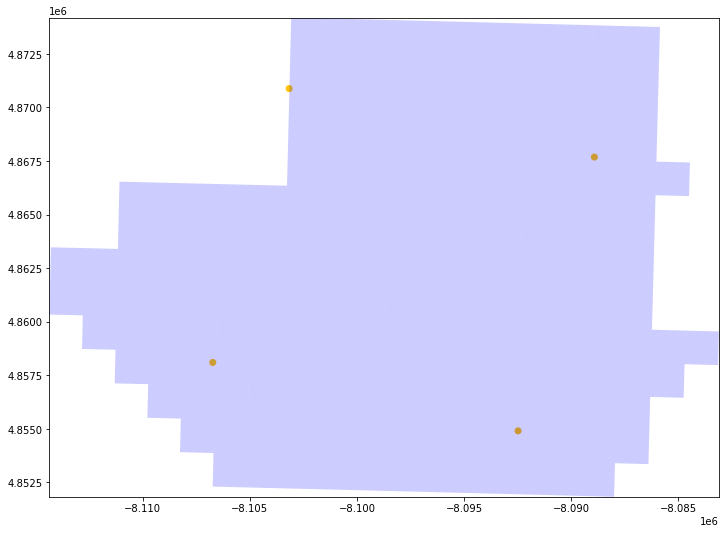

In [171]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-8114361.19826695, -8083105.2395973])
ax.set_ylim([4851827.76684288, 4874200.74436741])
nrel_open_gdf.plot(ax=ax, column="wind_speed_150meters", cmap ="nipy_spectral")
ocs_a_0537_geom.plot(ax=ax, alpha=0.2, color="blue")

In [172]:
ocs_a_0537_wind_speeds = gpd.sjoin(nrel_open_gdf, ocs_a_0537_geom)
ocs_a_0537_wind_speeds

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km,...,PROT_NUMBE,BLOCK_NUMB,BLOCK_LAB,SUB_BLK,LINK1,LINK2,CAT1,OBJECTID,Shape_Leng,Shape_Area
5814,5814,40.012,-72.664,109.5849,582.402742,0.452958,9.441864,7.660143,-57.472244,83.600945,...,NK18-12,7072,None,None,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
5900,5900,39.946,-72.824,108.1026,574.524872,0.450712,9.411641,5.500000,-52.722538,86.384750,...,NJ18-03,6019G,6019,G,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
5901,5901,39.924,-72.696,97.6617,519.035395,0.452783,9.446178,5.500000,-55.345524,91.720781,...,NJ18-03,6022,None,None,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0


In [173]:
ocs_a_0538_geom = nyb_geom[nyb_geom["INFO"].str.contains("^.*OCS-A\s*0538.*$")]
ocs_a_0538_geom.total_bounds

array([-8160436.51911996,  4809036.26432264, -8127768.8885724 ,
        4840861.17451456])

<AxesSubplot:>

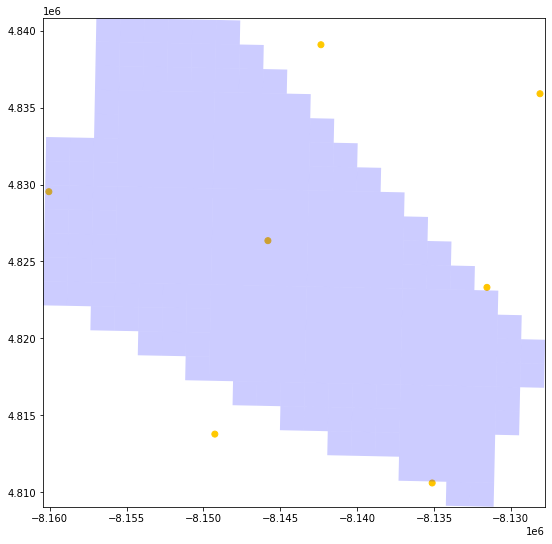

In [174]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-8160436.51911996, -8127768.8885724])
ax.set_ylim([4809036.26432264, 4840861.17451456])
nrel_open_gdf.plot(ax=ax, column="wind_speed_150meters", cmap ="nipy_spectral")
ocs_a_0538_geom.plot(ax=ax, alpha=0.2, color="blue")

In [175]:
ocs_a_0538_wind_speeds = gpd.sjoin(nrel_open_gdf, ocs_a_0538_geom)
ocs_a_0538_wind_speeds

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km,...,PROT_NUMBE,BLOCK_NUMB,BLOCK_LAB,SUB_BLK,LINK1,LINK2,CAT1,OBJECTID,Shape_Leng,Shape_Area
6133,6133,39.749,-73.303,90.4203,480.550064,0.445285,9.314487,6.931097,-39.262653,64.162527,...,NJ18-03,6261B,6261,B,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
6134,6134,39.727,-73.175,111.1887,590.926339,0.446963,9.351187,6.931097,-42.282146,74.098016,...,NJ18-03,6263,None,None,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0


In [176]:
ocs_a_0539_geom = nyb_geom[nyb_geom["INFO"].str.contains("^.*OCS-A\s*0539.*$")]
ocs_a_0539_geom.total_bounds

array([-8181232.55819279,  4781508.16557609, -8137373.8187093 ,
        4817450.24014925])

<AxesSubplot:>

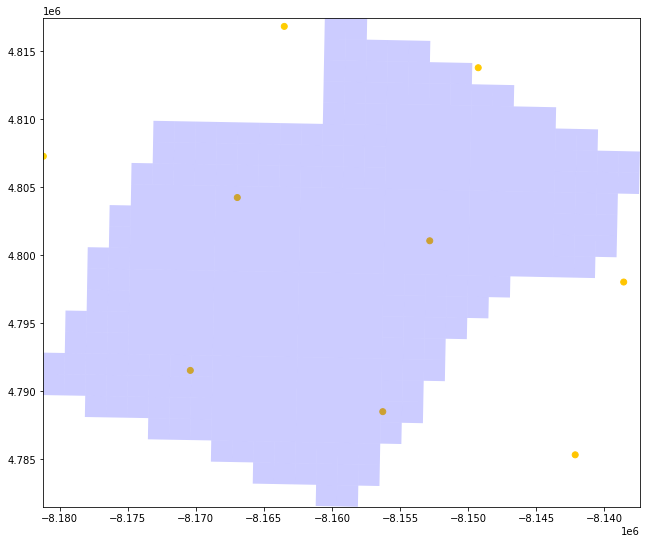

In [177]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-8181232.55819279, -8137373.8187093])
ax.set_ylim([4781508.16557609, 4817450.24014925])
nrel_open_gdf.plot(ax=ax, column="wind_speed_150meters", cmap ="nipy_spectral")
ocs_a_0539_geom.plot(ax=ax, alpha=0.2, color="blue")

In [178]:
ocs_a_0539_wind_speeds = gpd.sjoin(nrel_open_gdf, ocs_a_0539_geom)
ocs_a_0539_wind_speeds

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km,...,PROT_NUMBE,BLOCK_NUMB,BLOCK_LAB,SUB_BLK,LINK1,LINK2,CAT1,OBJECTID,Shape_Leng,Shape_Area
6289,6289,39.574,-73.365,111.8610,594.499362,0.444935,9.318565,6.931097,-33.538162,62.776945,...,NJ18-03,6460,None,None,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
6290,6290,39.552,-73.238,112.7844,599.406888,0.446649,9.355652,6.931097,-37.595089,73.373523,...,NJ18-03,6462,None,None,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
6372,6372,39.486,-73.396,112.7844,599.406888,0.444510,9.321439,6.931097,-33.904480,64.230148,...,NJ18-03,6559C,6559,C,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
6373,6373,39.465,-73.269,109.8117,583.608099,0.446239,9.360031,6.931097,-37.819134,74.532680,...,NJ18-03,6562I,6562,I,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0


In [179]:
ocs_a_0541_geom = nyb_geom[nyb_geom["INFO"].str.contains("^.*OCS-A\s*0541.*$")]
ocs_a_0541_geom.total_bounds

array([-8198913.4648241 ,  4749489.93083611, -8176654.96632869,
        4791523.68750027])

<AxesSubplot:>

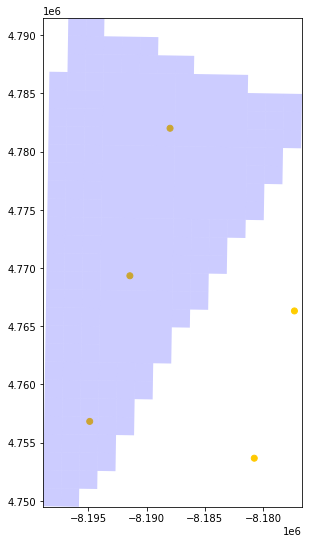

In [180]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-8198913.4648241, -8176654.96632869])
ax.set_ylim([4749489.93083611, 4791523.68750027])
nrel_open_gdf.plot(ax=ax, column="wind_speed_150meters", cmap ="nipy_spectral")
ocs_a_0541_geom.plot(ax=ax, alpha=0.2, color="blue")

In [181]:
ocs_a_0541_wind_speeds = gpd.sjoin(nrel_open_gdf, ocs_a_0541_geom)
ocs_a_0541_wind_speeds

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km,...,PROT_NUMBE,BLOCK_NUMB,BLOCK_LAB,SUB_BLK,LINK1,LINK2,CAT1,OBJECTID,Shape_Leng,Shape_Area
6453,6453,39.420,-73.554,112.7844,599.406888,0.443086,9.292164,6.931097,-38.699081,56.024551,...,NJ18-03,6606,None,None,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
6533,6533,39.332,-73.585,112.7844,599.406888,0.443310,9.304317,6.931097,-43.130711,58.599398,...,NJ18-03,6706,None,None,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
6613,6613,39.245,-73.616,106.2882,564.882015,0.443845,9.317607,5.500000,-43.436138,61.650074,...,NJ18-03,6805P,6805,P,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0


In [182]:
ocs_a_0542_geom = nyb_geom[nyb_geom["INFO"].str.contains("^.*OCS-A\s*0542.*$")]
ocs_a_0542_geom.total_bounds

array([-8195820.50949141,  4749190.03910299, -8161253.88921667,
        4783403.73413508])

<AxesSubplot:>

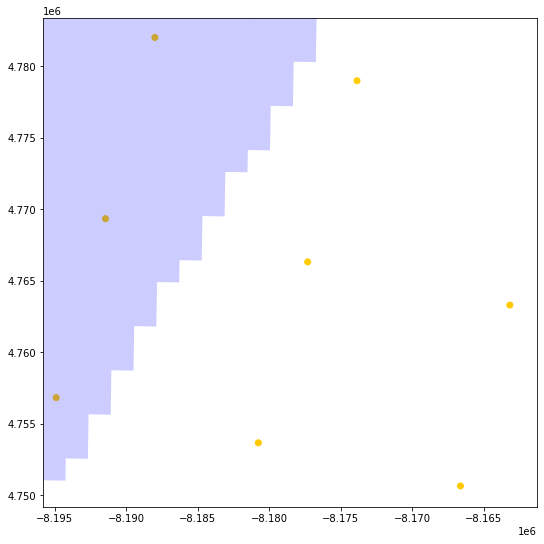

In [183]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-8195820.50949141, -8161253.88921667])
ax.set_ylim([4749190.03910299, 4783403.73413508])
nrel_open_gdf.plot(ax=ax, column="wind_speed_150meters", cmap ="nipy_spectral")
ocs_a_0541_geom.plot(ax=ax, alpha=0.2, color="blue")

In [184]:
ocs_a_0542_wind_speeds = gpd.sjoin(nrel_open_gdf, ocs_a_0542_geom)
ocs_a_0542_wind_speeds

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km,...,PROT_NUMBE,BLOCK_NUMB,BLOCK_LAB,SUB_BLK,LINK1,LINK2,CAT1,OBJECTID,Shape_Leng,Shape_Area
6454,6454,39.399,-73.427,112.7844,599.406888,0.444726,9.330740,6.931097,-39.619076,66.367617,...,NJ18-03,6659,None,None,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
6534,6534,39.311,-73.458,112.7844,599.406888,0.445158,9.342335,6.931097,-45.008690,68.879547,...,NJ18-03,6758,None,None,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0
6614,6614,39.223,-73.489,110.7108,588.386480,0.445438,9.349626,5.500000,-43.688908,71.634789,...,NJ18-03,6858E,6858,E,https://www.boem.gov/renewable-energy/state-ac...,https://www.boem.gov/renewable-energy/state-ac...,New York Bight FSN,0,0.0,0.0


In [187]:
clean_merged_cf["Wind Speed (m/s)"] = None
clean_merged_cf["Landfall Distance to Transmission (km)"] = None

mask = clean_merged_cf["ID"].str.contains("OCS-A 0544")
clean_merged_cf.loc[mask, "Wind Speed (m/s)"] = ocs_a_0544_wind_speeds["wind_speed_150meters"].mean()
clean_merged_cf.loc[mask, ("Landfall Distance to Transmission (km)",)] = ocs_a_0544_wind_speeds["landfall_distance_to_transmission_km"].mean()

mask = clean_merged_cf["ID"].str.contains("OCS-A 0537")
clean_merged_cf.loc[mask, ("Wind Speed (m/s)",)] = ocs_a_0537_wind_speeds["wind_speed_150meters"].mean()
clean_merged_cf.loc[mask, ("Landfall Distance to Transmission (km)",)] = ocs_a_0537_wind_speeds["landfall_distance_to_transmission_km"].mean()

mask = clean_merged_cf["ID"].str.contains("OCS-A 0538")
clean_merged_cf.loc[mask, ("Wind Speed (m/s)",)] = ocs_a_0538_wind_speeds["wind_speed_150meters"].mean()
clean_merged_cf.loc[mask, ("Landfall Distance to Transmission (km)",)] = ocs_a_0538_wind_speeds["landfall_distance_to_transmission_km"].mean()

mask = clean_merged_cf["ID"].str.contains("OCS-A 0539")
clean_merged_cf.loc[mask, ("Wind Speed (m/s)",)] = ocs_a_0539_wind_speeds["wind_speed_150meters"].mean()
clean_merged_cf.loc[mask, ("Landfall Distance to Transmission (km)",)] = ocs_a_0539_wind_speeds["landfall_distance_to_transmission_km"].mean()

mask = clean_merged_cf["ID"].str.contains("OCS-A 0541")
clean_merged_cf.loc[mask, ("Wind Speed (m/s)",)] = ocs_a_0541_wind_speeds["wind_speed_150meters"].mean()
clean_merged_cf.loc[mask, ("Landfall Distance to Transmission (km)",)] = ocs_a_0541_wind_speeds["landfall_distance_to_transmission_km"].mean()

mask = clean_merged_cf["ID"].str.contains("OCS-A 0542")
clean_merged_cf.loc[mask, ("Wind Speed (m/s)",)] = ocs_a_0542_wind_speeds["wind_speed_150meters"].mean()
clean_merged_cf.loc[mask, ("Landfall Distance to Transmission (km)",)] = ocs_a_0542_wind_speeds["landfall_distance_to_transmission_km"].mean()

clean_merged_cf

,ID,Acres,Developable Acres,Installation Capacity (MW) [1],Homes powered [2],Power Production (MWh/yr) [3],Max Depth (meters[m]),Min Depth (m),Closest distance to NY (nautical mile [nmi]),Closest distance to NJ (nmi),operator,bid,Price Per Acre,Wind Speed (m/s),Landfall Distance to Transmission (km)
0,OCS-A 0537,71522.0,71522.0,868.0,303911.0,3042588.0,61.0,50.0,38.0,53.0,OW Ocean Winds East LLC,7.650000e+08,10696.009619,9.433228,6.220048
1,OCS-A 0538,84332.0,79438.0,964.0,337548.0,3379340.0,63.0,37.0,47.0,36.0,Attentive Energy LLC,7.950000e+08,10007.804829,9.332837,6.931097
2,OCS-A 0539,125964.0,114277.0,1387.0,485586.0,4861411.0,51.0,31.0,56.0,32.0,Bight Wind Holdings LLC,1.100000e+09,9625.733962,9.338922,6.931097
3,OCS-A 0541,79351.0,76139.0,924.0,323530.0,3238998.0,51.0,31.0,65.0,27.0,Atlantic Shores Offshore Wind Bight LLC,7.800000e+08,10244.421387,9.304696,6.454065
4,OCS-A 0542,83976.0,76894.0,934.0,326738.0,3271116.0,54.0,32.0,69.0,35.0,Invenergy Wind Offshore LLC,6.450000e+08,8388.170729,9.3409,6.454065
5,OCS-A 0544,43056.0,43056.0,523.0,182954.0,1831628.0,46.0,40.0,20.0,36.0,Mid-Atlantic Offshore Wind LLC,2.850000e+08,6619.286511,9.253782,5.5


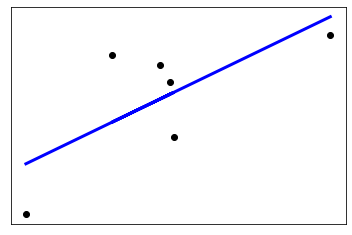

In [190]:
# Correlate price per acre with avg wind speed
from sklearn import linear_model

x = clean_merged_cf["Wind Speed (m/s)"].values
y = clean_merged_cf["Price Per Acre"].values

x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

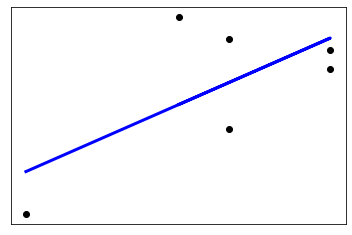

In [191]:
# Correlate price per acre with avg onshore distance to electrical transmission

x = clean_merged_cf["Landfall Distance to Transmission (km)"].values
y = clean_merged_cf["Price Per Acre"].values

x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

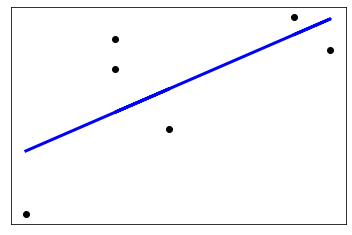

In [192]:
# Correlate price per acre with max water depth

x = clean_merged_cf["Max Depth (meters[m])"].values
y = clean_merged_cf["Price Per Acre"].values

x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

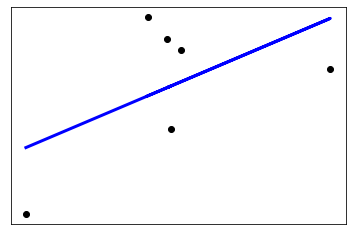

In [193]:
# Correlate price per acre with annual power production

x = clean_merged_cf["Power Production (MWh/yr) [3]"].values
y = clean_merged_cf["Price Per Acre"].values

x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

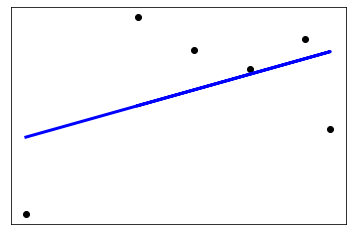

In [194]:
# Correlate price per acre with distance to New York shore

x = clean_merged_cf["Closest distance to NY (nautical mile [nmi])"].values
y = clean_merged_cf["Price Per Acre"].values

x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

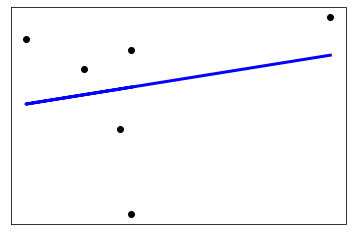

In [195]:
# Correlate price per acre with distance to New Jersey shore

x = clean_merged_cf["Closest distance to NJ (nmi)"].values
y = clean_merged_cf["Price Per Acre"].values

x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

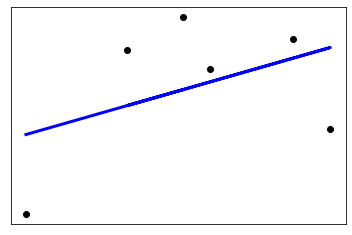

In [198]:
# Correlate price per acre with maximum distance to shore

xny = clean_merged_cf["Closest distance to NY (nautical mile [nmi])"].values
xnj = clean_merged_cf["Closest distance to NJ (nmi)"].values
x = np.fmax(xny, xnj)
y = clean_merged_cf["Price Per Acre"].values

x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# Peform multi-variable regression using all above features
